## Visual Similarity Clustering in an Image

In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import ndimage
from skimage import measure, color, segmentation
from skimage.segmentation import clear_border
import seaborn as sns

In [2]:
def showimg(img, cmap=None):
    fig = plt.figure(figsize=(9, 6))
    plt.imshow(img, cmap = cmap ,vmin=0, vmax=255)
    plt.axis('off')
    plt.show()

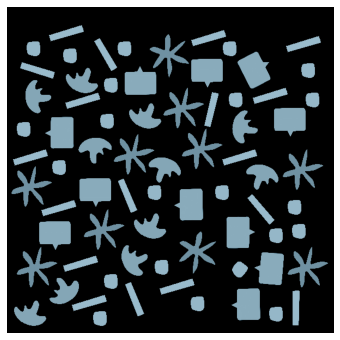

In [3]:
img = cv2.imread('shapes2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(9, 6))
plt.imshow(img, cmap = None, vmin=0, vmax=255)
plt.axis('off')
plt.show()

## Color to Grayscale

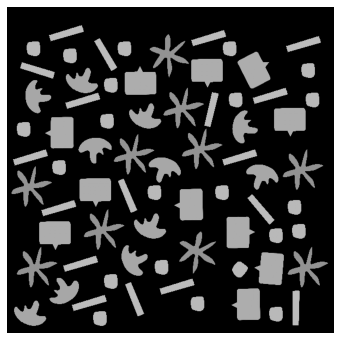

In [4]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
showimg(gray,"gray")

## Thresholding 

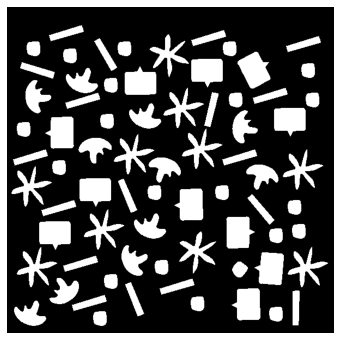

In [5]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
mean_val = gray.mean()
bw = np.where(gray > mean_val, 255, 0)
showimg(bw,"gray")

## Erosion 
* https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html

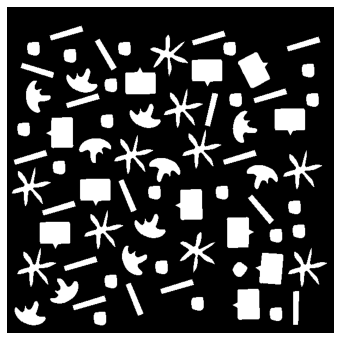

In [6]:
from skimage.morphology import erosion
from skimage.morphology import disk  

footprint = disk(1)
cleared_bw = erosion(bw, footprint)
showimg(cleared_bw,'gray')

## Labelling the shapes in the image
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html

In [7]:
connection = [[1,1,1],[1,1,1],[1,1,1]]
label_image, num_labels = ndimage.label(cleared_bw, structure=connection)
print('shape number in the image  :', num_labels)

shape number in the image  : 72


## Feature Extraction from labelled areas

* https://scikit-image.org/docs/0.19.x/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops
* https://scikit-image.org/docs/0.19.x/api/skimage.measure.html?highlight=regionprops_table#skimage.measure.regionprops_table

In [8]:
prop_list = [
      'label', 
      'area_convex', 
      'area_filled',
      'eccentricity',
      'perimeter',
      'solidity'
      ]

In [9]:
k = measure.regionprops_table(label_image, 
                          intensity_image=img, 
                          properties=(prop_list),  
                          cache=True, separator=',', 
                          extra_properties=None)

df = pd.DataFrame(k)
df.head(5)

,label,area_convex,area_filled,eccentricity,perimeter,solidity
0,1,686,629,0.985911,150.154329,0.916910
1,2,686,629,0.985911,150.154329,0.916910
2,3,3613,1285,0.281202,381.297511,0.355660
3,4,686,629,0.985911,150.154329,0.916910
4,5,696,646,0.985297,150.409163,0.928161


In [10]:
def normalize(col):
    return (col - col.mean()) / col.std()


for col in df.columns:
    if col != 'label':
        df[col] = normalize(df[col])
    
df.head(3)

,label,area_convex,area_filled,eccentricity,perimeter,solidity
0,1,-0.715783,-0.655106,1.443569,-0.273066,0.438474
1,2,-0.715783,-0.655106,1.443569,-0.273066,0.438474
2,3,1.922556,0.403282,-1.284933,2.177072,-2.282470


### Feature Correlation 

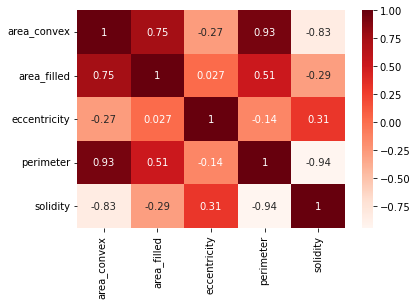

In [11]:
plt.figure(figsize=(6,4))
cor = df.iloc[:,1:].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## K-means Clustering 

In [12]:
from sklearn.cluster import KMeans

In [13]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df.iloc[:,1:])

In [14]:
labels = kmeans.labels_
labels

array([0, 0, 1, 0, 0, 2, 2, 2, 2, 4, 4, 0, 2, 4, 3, 2, 3, 0, 1, 0, 0, 2,
       2, 3, 4, 3, 2, 4, 2, 1, 1, 3, 0, 0, 1, 3, 2, 3, 1, 4, 0, 2, 2, 4,
       0, 0, 2, 1, 3, 4, 4, 2, 2, 1, 3, 1, 1, 4, 0, 2, 2, 2, 3, 0, 0, 4,
       0, 0, 2, 3, 2, 2], dtype=int32)

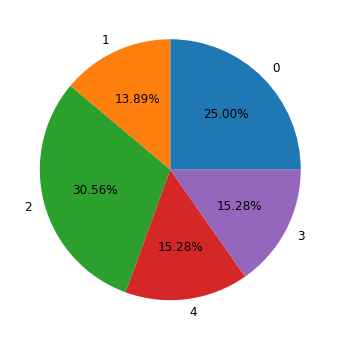

In [15]:
from collections import Counter
cnts = dict(Counter(labels))
fig,ax  = plt.subplots(figsize=(10,6))
ax.pie(x =list(cnts.values()), labels=list(cnts.keys()) ,  autopct="%.2f%%", 
       textprops={'fontsize': 12, 'color': 'black'})
plt.show()

## Coloring the shapes based on the clusters

In [16]:
cluster_color = label_image

In [17]:
for shape in list(df['label']):
    shape_features = df.loc[df['label'] == shape]
    pred = kmeans.predict(shape_features.iloc[:,1:])[0]
    cluster_color [cluster_color  == shape] = pred +1
    

In [18]:
np.unique(cluster_color)

array([0, 1, 2, 3, 4, 5], dtype=int32)

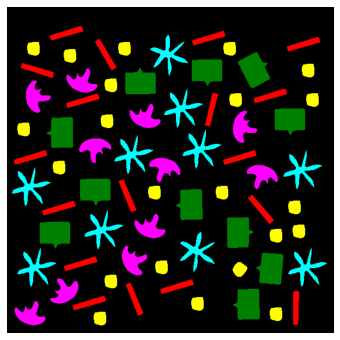

In [19]:
color_label = color.label2rgb(cluster_color, bg_label = 0,
                              colors = ['red', 'cyan', 'yellow', 'magenta', 'green'])
showimg(color_label)

## Evaluation of the clustering

* https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

In [20]:
from sklearn import metrics

In [21]:
metrics.calinski_harabasz_score(df.iloc[:,1:], labels)

34010.655852037125

In [22]:
metrics.davies_bouldin_score(df.iloc[:,1:], labels)

0.03250132022985535